## Market classification based on intermarket indicators
--- Alan, Shaolun.du@gmail.com

Intermarket correlation is always significant...
In this notebook, I am trying to classify SP500 market index based on Fed fund rate, US government bond yields spread of 10Y-2Y and 30Y-10Y, gold price and dollar index for the past 20 years.
Specifically, I will do the following:
0. Data preprocess:
    * label historical data with 0-4 categories (0=short,2=oscillation,4=long)
    * feature smoothing and normalization
1. Build model:
    * setup layers, specify the model
    * split dataset into dev/test set
2. Trian model:
    * feed and calibrate model based on dev model
    * evaluate model based on dev set
    * make prediction and verify predictions on test set
3. Use trained model for ongoing new data

### 0. Import library

In [1]:
# Data loading
%matplotlib inline
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from abc import ABC, abstractmethod
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
# Global variable declaration
_r_f = 0.001 # rsik free rate
_day_year = 252 # trading days in a year
rets = lambda x: (x[-1] - x[0]) / x[0]
diffs = lambda x: x[-1] - x[0]

In [2]:
# systematic labeling function
def sys_label(df,paras):
    if paras["method"] == "BollBand":
        df["mean"]  = df["SP"].rolling(look_back).mean()
        df["width"] = df["SP"].rolling(look_back).std()*paras["multi"]
        df["label"] = np.where(df['SP']>=df["mean"]+df["width"],4,
                              np.where(df['SP']>=df["mean"]+df["width"]/2,3,
                                      np.where(df['SP']>=df["mean"]-df["width"]/2,2,
                                              np.where(df['SP']>=df["mean"]-df["width"],1,0))))
    return df[["label"]]

### 1. Data preprocess

In [3]:
# Data loading
systematic_label = True
look_back = 60
raw = pd.read_excel("Data.xlsx").set_index("Dates")
raw["SP"]      = raw["SPX Index"]
raw["SP_Roll"] = (raw["SP2 Index"]-raw["SP1 Index"])/raw["SP1 Index"]
raw["SP_Rets"] = raw["SPX Index"].pct_change()
raw["SP_Vol"]  = raw["SP_Rets"].rolling(look_back).std()
raw["Gold"]    = raw["XAU Curncy"]
raw["Dollar"]  = raw["DXY Curncy"]
raw["Fed01"]   = raw["FEDL01 Index"]
raw["Spread_10_2"]  = raw["USGG10YR Index"]- raw["USGG2YR Index"]
raw["Spread_30_10"] = raw["USGG30YR Index"]- raw["USGG10YR Index"]
# Read label data
if not systematic_label:
    label = pd.read_excel("labeled.xlsx").set_index("Dates")
else:
    paras = {}
    paras["method"]   = "BollBand"
    paras["lookback"] = 120
    paras["multi"]    = 2
    label = sys_label(raw[["SP"]],paras)
raw = raw.join(label,how='inner').dropna()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [11]:
# data smoothing
var_select = ["SP_Roll","SP_Vol","Fed01",
              "Gold","Dollar","Spread_10_2",
              "Spread_30_10"]
for ticker in var_select:
    if ticker != "SP":
        raw[ticker+"_Smooth"] = savgol_filter(raw[ticker],51,3)
# Compute changes(diffs or returns) in variables
N = 30
raw["SP_Vol_chg"]  = raw["SP_Vol"+"_Smooth"].rolling(N).apply(diffs,raw=False)
raw["SP_Roll_chg"] = raw["SP_Roll"+"_Smooth"].rolling(N).apply(diffs,raw=False)
raw["Fed01_chg"]   = raw["Gold"+"_Smooth"].rolling(N).apply(diffs,raw=False)
raw["Gold_chg"]    = raw["Gold"+"_Smooth"].rolling(N).apply(rets,raw=False)
raw["Dollar_chg"]  = raw["Dollar"+"_Smooth"].rolling(N).apply(rets,raw=False)
raw["Spread_10_2_chg"] = raw["Spread_10_2"+"_Smooth"].rolling(N).apply(diffs,raw=False)
raw["Spread_30_10_chg"] = raw["Spread_30_10"+"_Smooth"].rolling(N).apply(diffs,raw=False)
# Peek into our dataset
# correlation martrix
# total_var_select = ["SP_Roll_chg","SP_Vol_chg","Fed01_chg",
#                     "Gold_chg","Dollar_chg","Spread_10_2_chg",
#                     "Spread_30_10_chg"]
total_var_select = ["SP_Roll_chg","SP_Vol_chg",
                    "Gold_chg","Dollar_chg","Spread_10_2_chg",
                    "Spread_30_10_chg"]
addOn = ["SP","label"]
data = raw[total_var_select].dropna()
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,SP_Roll_chg,SP_Vol_chg,Gold_chg,Dollar_chg,Spread_10_2_chg,Spread_30_10_chg
SP_Roll_chg,1,-0.24,-0.087,-0.017,-0.39,-0.38
SP_Vol_chg,-0.24,1,-0.051,0.17,0.031,0.021
Gold_chg,-0.087,-0.051,1,-0.44,-0.073,0.26
Dollar_chg,-0.017,0.17,-0.44,1,0.021,-0.29
Spread_10_2_chg,-0.39,0.031,-0.073,0.021,1,0.17
Spread_30_10_chg,-0.38,0.021,0.26,-0.29,0.17,1


In [12]:
# using Min-Max scaler to normalize data
x = data.values
idx = data.index
cols = data.columns
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normal_data = pd.DataFrame(x_scaled,index=idx,columns=cols)
normal_data = normal_data.join(raw[addOn])

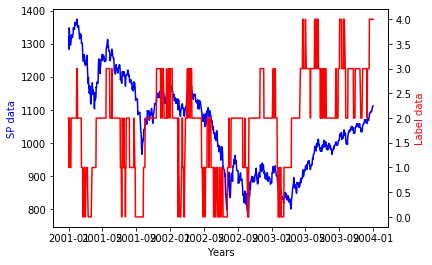

Dev set shape:(783, 8)
Test set shape:(108, 8)


In [38]:
# Seperating dev set and test set
dev_start = normal_data.index.searchsorted(dt.datetime(2001, 1, 1))
dev_end   = normal_data.index.searchsorted(dt.datetime(2004, 1, 1))
tst_start = normal_data.index.searchsorted(dt.datetime(2004, 1, 1))
tst_end   = normal_data.index.searchsorted(dt.datetime(2004, 6, 1))

dev_set = normal_data.iloc[dev_start:dev_end]
test_set = normal_data.iloc[tst_start:tst_end]
# Quick showing of development set labeling
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dev_set["SP"], label = "SP",color='b')
ax2.plot(dev_set.index,dev_set["label"], label = "label",color='r')
ax1.set_xlabel('Years')
ax1.set_ylabel('SP data',color='b')
ax2.set_ylabel('Label data',color='r')
plt.show()
print("=======================")
print("Dev set shape:{}".format(dev_set.shape))
print("Test set shape:{}".format(test_set.shape))

### 2. Compile model

In [39]:
# model specification
model = keras.Sequential([
    keras.layers.Dense(10, input_shape=(len(total_var_select),)),
    keras.layers.Dense(5),
    keras.layers.Dense(5)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# train on dev set
X = dev_set[total_var_select]
y = dev_set['label']
model.fit(X, y, epochs=10)

Epoch 1/10
25/25 [==============================] - 0s 766us/step - loss: 1.5500 - accuracy: 0.4112
Epoch 2/10
25/25 [==============================] - 0s 761us/step - loss: 1.4865 - accuracy: 0.4559
Epoch 3/10
25/25 [==============================] - 0s 724us/step - loss: 1.4465 - accuracy: 0.4559
Epoch 4/10
25/25 [==============================] - 0s 703us/step - loss: 1.4111 - accuracy: 0.4559
Epoch 5/10
25/25 [==============================] - 0s 783us/step - loss: 1.3811 - accuracy: 0.4559
Epoch 6/10
25/25 [==============================] - 0s 760us/step - loss: 1.3580 - accuracy: 0.4559
Epoch 7/10
25/25 [==============================] - 0s 692us/step - loss: 1.3387 - accuracy: 0.4559
Epoch 8/10
25/25 [==============================] - 0s 705us/step - loss: 1.3245 - accuracy: 0.4585
Epoch 9/10
25/25 [==============================] - 0s 911us/step - loss: 1.3125 - accuracy: 0.4623
Epoch 10/10
25/25 [==============================] - 0s 893us/step - loss: 1.3023 - accuracy: 0.4764

#### Evaluate on dev set and predicte on test set

In [40]:
X_test = test_set[total_var_select]
y_test = test_set['label']
test_loss, test_acc = model.evaluate(X_test,y_test,verbose=2)
print('Test accuracy:{:0.4f}'.format(test_acc))

4/4 - 0s - loss: 1.3934 - accuracy: 0.4259
Test accuracy:0.4259


### Evaluate model based on chaining validation